# 실습:  CNN을 이용한 폐렴 검출

The code below is copied from
 https://www.kaggle.com/kashyapgohil/pneumonia-detection-using-cnn

 The Author of the code is Kashyap Gohil

 영상 데이터셋은 다음 링크에서 얻을 수 있다: 
 https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia 

데이터셋에 대한 설명:
데이터 세트는 3개의 폴더(train, test, validation)로 구성되며 각각에 대하여 클래스 (폐렴/정상)에 대한 하위 폴더를 포함하고 있다. 본 데이터세트는 5,863개의 X선 영상(JPEG)으로 이루어졌고,광저우시 광저우 여성아동병원에서 1~5세 소아환자를 대상으로 촬영한 흉부 X선 영상이다. 저품질 또는 판독이 불가능한 영상은 제외가 되었고, 두 명의 전문의에 의해 이미지에 대한 진단 점수가 매겨졌다. 

In [ ]:
from google.colab import drive

# 구글 드라이브 마운트
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 압축 파일 복사
!cp "/content/drive/MyDrive/지핕/archive.zip" "/content/archive.zip"

In [ ]:
# 압축파일 풀기
!unzip "/content/archive.zip"

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating: chest_xray/tra

In [ ]:
# 필요한 모듈 import하기
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
import os

In [ ]:
# 파일로부터 영상을 읽어서 data에 저장하기
labels = ['PNEUMONIA', 'NORMAL']
img_size = 299
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [ ]:
ls

archive.zip  chest_xray/  drive/  model.h5  sample_data/


In [ ]:
cd archive

[Errno 2] No such file or directory: 'archive'
/content


In [ ]:
ls

archive.zip  chest_xray/  drive/  model.h5  sample_data/


In [ ]:
cd chest_xray

/content/chest_xray


In [ ]:
ls

chest_xray/  __MACOSX/  test/  train/  val/


In [ ]:
cd ..

/content


In [ ]:
train = get_training_data('./chest_xray/train')
test = get_training_data('./chest_xray/test')
#val = get_training_data('./chest_xray/val')

<ipython-input-5-5d52e056e3f6>:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


In [ ]:
print(train[500][1])

0


In [ ]:
train.shape

(5216, 2)

In [ ]:
for feature, label in train:
  print(feature)
  print(label)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
[[145 121 107 ...   7   3   0]
 [141 119 103 ...   4   2   0]
 [143 122 105 ...   5   0   0]
 ...
 [ 68  68  67 ...   0   0   0]
 [ 67  64  68 ...   0   0   0]
 [ 73  60  68 ...   0   0   0]]
1
[[128 122 119 ...  64  61  56]
 [127 119 120 ...  63  58  55]
 [135 123 118 ...  62  55  53]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]
1
[[ 0  0  0 ... 42 36 29]
 [ 0  0  0 ... 41 30 28]
 [ 0  0  0 ... 37 26 20]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]
1
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
1
[[ 50  58  63 ... 113 134 162]
 [ 47  56  61 ... 109 132 162]
 [ 45  53  59 ... 114 130 161]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]
1
[[71 68 75 ... 68 68 70]
 [71 69 71 ... 69 66 69]
 [69 67 71 ... 72 71 78]
 ...
 [ 1  0  0 ... 43 39 2

<Axes: ylabel='count'>

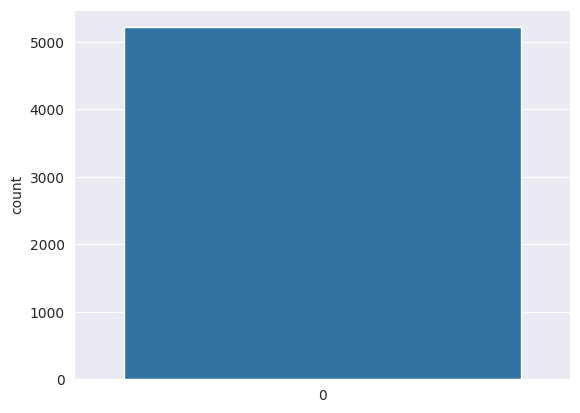

In [ ]:
#폐렴과 정상 데이터의 갯수 확인하기
l = []
for i in train:
    if(i[1] == 0):
        l.append(0)  # "Pneumonia"를 0으로 변환
    else:
        l.append(1)  # "Normal"을 1로 변환
sns.set_style('darkgrid')
sns.countplot(l)


Text(0.5, 1.0, 'NORMAL')

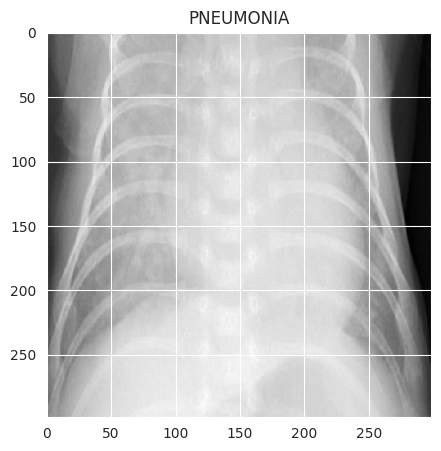

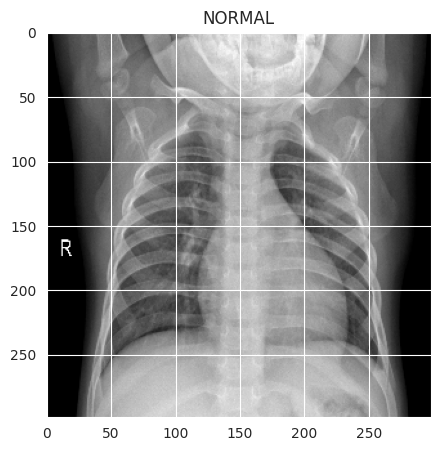

In [ ]:
#영상으로 보이기
plt.figure(figsize = (5,5))
plt.imshow(train[0][0], cmap='gray')
plt.title(labels[train[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0], cmap='gray')
plt.title(labels[train[-1][1]])

In [ ]:
x_train = []
y_train = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
#for feature, label in val:
#    x_val.append(feature)
#    y_val.append(label)

In [ ]:
# 데이터를 Normalize 0~255  --->   0~1
x_train = np.array(x_train) / 255
#x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

In [ ]:
# 딥러닝을 위해 data를 resize
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

# x_val = x_val.reshape(-1, img_size, img_size, 3)
# y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

In [ ]:
# data augmentation하기 (overfitting을 막고, 데이터셋내의 데이터 불균형도 어느 정도 해소)

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

In [ ]:
# 모델을 만들기
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 150, 150, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 dropout (Dropout)           (None, 75, 75, 64)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 75, 75, 64)       2

In [ ]:
#learning_rate를 줄이는 방법. 
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 5, verbose=1,factor=0.3, min_lr=0.000001)

In [ ]:
history = model.fit(datagen.flow(x_train,y_train, batch_size = 32) ,epochs = 12 ,callbacks = [learning_rate_reduction])

Epoch 1/12


InvalidArgumentError: ignored

In [ ]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

In [ ]:
epochs = [i for i in range(12)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [ ]:
predictions = model.predict_classes(x_test)
predictions = predictions.reshape(1,-1)[0]
predictions[:15]

In [ ]:
print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

In [ ]:
cm = confusion_matrix(y_test,predictions)
cm

In [ ]:
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])

In [ ]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)

In [ ]:
correct = np.nonzero(predictions == y_test)[0]
incorrect = np.nonzero(predictions != y_test)[0]

In [ ]:
i = 0
for c in correct[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1

In [ ]:
#model.save(../model.h5)